In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./AirPassengers.csv').rename(columns={'Month': 'Date'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,#Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## Time Series Plot

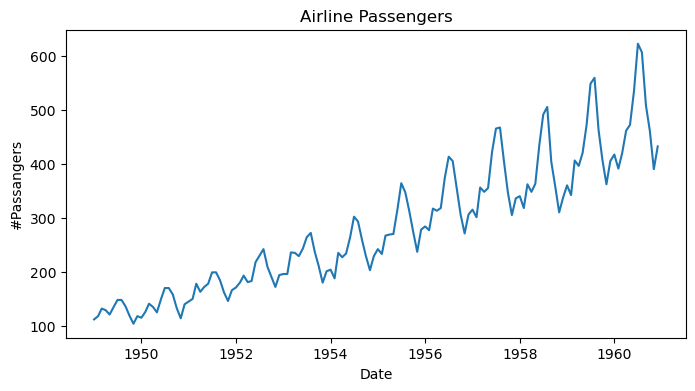

In [4]:
plt.figure(figsize=(8,4))
plt.plot(df)
plt.title('Airline Passengers')
plt.xlabel('Date')
plt.ylabel('#Passangers')
plt.show()

## Time Series division

In [5]:
train, val, test = df.loc['1949':'1957'], df.loc['1958':'1959'], df.loc['1960':]

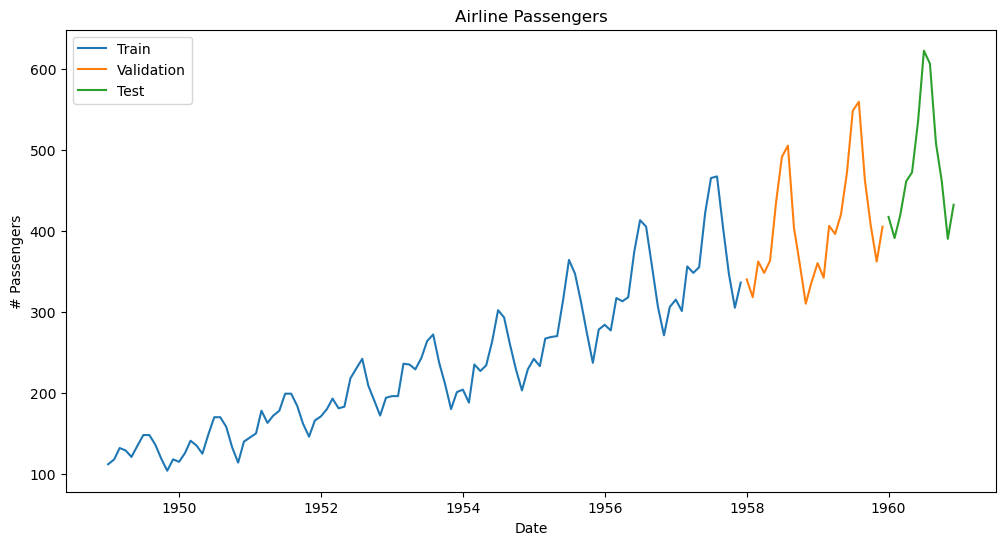

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label='Train')
plt.plot(val.index, val.values, label='Validation')
plt.plot(test.index, test.values, label='Test')
plt.title('Airline Passengers')
plt.xlabel('Date')
plt.ylabel('# Passengers')
plt.legend()
plt.show()

## Autocorrelation

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
scaler.fit(train['#Passengers'].values.reshape(-1, 1))
train_norm = scaler.transform(train['#Passengers'].values.reshape(-1, 1))
val_norm = scaler.transform(val['#Passengers'].values.reshape(-1, 1))
test_norm = scaler.transform(test['#Passengers'].values.reshape(-1, 1))

In [9]:
train['#Passengers'].values

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336])

In [10]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

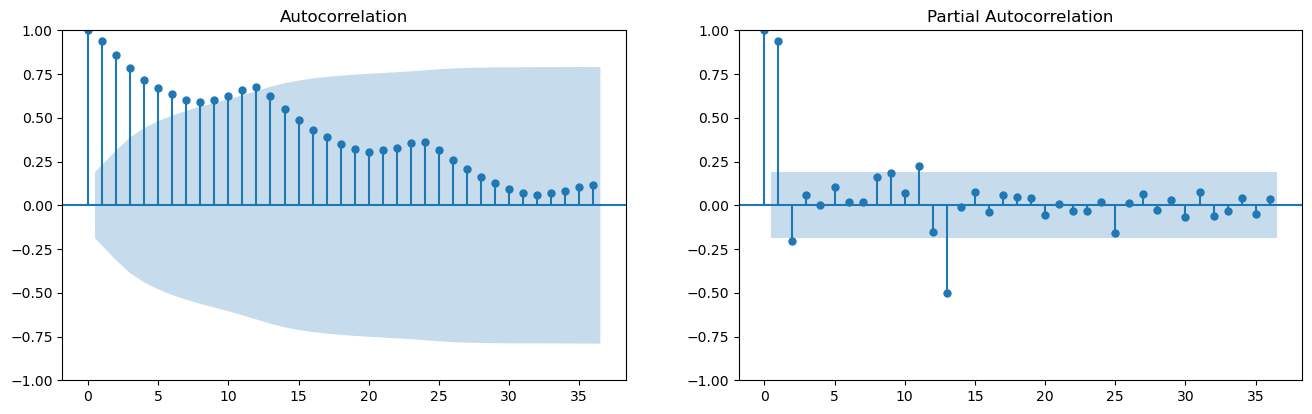

In [11]:
acf_pacf(train_norm, 36)

## Sliding windows

In [12]:
def create_sliding_windows(series, window_size):
    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [13]:
train_windows = create_sliding_windows(train_norm, 8)
val_windows = create_sliding_windows(val_norm, 8)
test_windows = create_sliding_windows(test_norm, 8)

In [14]:
train_windows.shape

(100, 9)

In [15]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1 ]
y_val = val_windows[: , -1 ]

X_test = test_windows[: ,0: -1 ]
y_test = test_windows[: , -1 ]

In [16]:
test_windows

array([[0.86225895, 0.79063361, 0.8677686 , 0.98347107, 1.0137741 ,
        1.18732782, 1.42699725, 1.38292011, 1.11294766],
       [0.79063361, 0.8677686 , 0.98347107, 1.0137741 , 1.18732782,
        1.42699725, 1.38292011, 1.11294766, 0.98347107],
       [0.8677686 , 0.98347107, 1.0137741 , 1.18732782, 1.42699725,
        1.38292011, 1.11294766, 0.98347107, 0.78787879],
       [0.98347107, 1.0137741 , 1.18732782, 1.42699725, 1.38292011,
        1.11294766, 0.98347107, 0.78787879, 0.90358127]])

## Grid search

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE

In [18]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error']
max_depths = [5, 10, 15]
mse_best = np.inf
best_params = None
for c in criterion:
  for d in max_depths:
    modelo = DecisionTreeRegressor(criterion=c, max_depth = d)
    modelo.fit(X_train, y_train)
    prev_val = modelo.predict(X_val)

    mse_val = MSE(y_val, prev_val)
    if mse_val < mse_best:
      mse_best = mse_val
      best_params = (c, d)

In [19]:
best_params

('friedman_mse', 5)

## Model training

In [20]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [21]:
X_train_full.shape

(116, 8)

In [22]:
y_train_full.shape

(116,)

In [23]:
model = DecisionTreeRegressor(criterion=best_params[0], max_depth=best_params[1])
model.fit(X_train_full, y_train_full)
prev_train = modelo.predict(X_train_full)

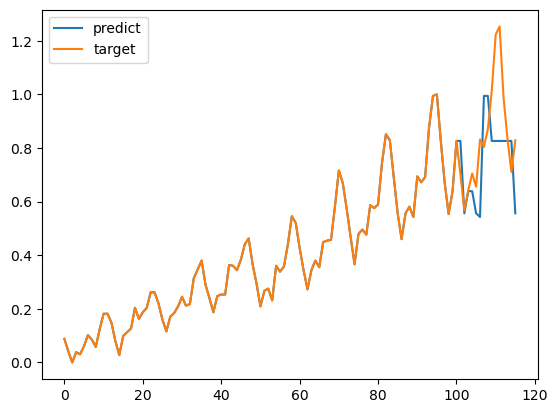

In [24]:
plt.plot(prev_train, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [25]:
MSE(y_train_full, prev_train)

0.0056371508028286695

In [26]:
y_real = scaler.inverse_transform(y_train_full.reshape(-1, 1))
predict_real = scaler.inverse_transform(prev_train.reshape(-1, 1))

In [27]:
MSE(y_real, predict_real)

742.8017241379307

In [28]:
prev_test = model.predict(X_test)

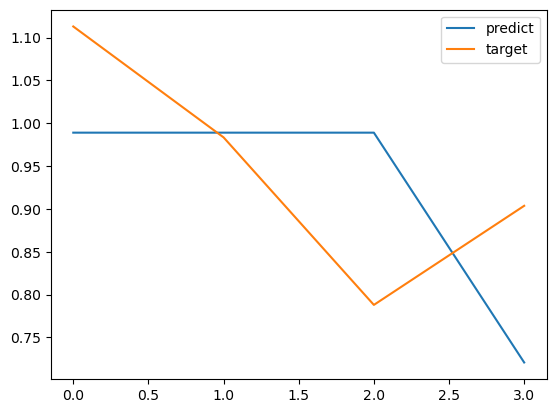

In [29]:
plt.plot(prev_test, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [30]:
MSE(y_test, prev_test)

0.022324977802062697

In [31]:
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))
predict_real = scaler.inverse_transform(prev_test.reshape(-1, 1))

In [32]:
MSE(y_real, predict_real)

2941.739999999997